In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
    pass

# Load the TensorBoard notebook extension
%load_ext tensorboard
logdir = './logs/'

# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'

# matplotlib rendering
%matplotlib inline

import sys
sys.path.append("../") # go to parent dir -> for module loading

TensorFlow 2.x selected.


In [0]:
!wget pollithy.com/Pfeffer.zip
!unzip -q Pfeffer.zip

--2020-01-09 18:56:08--  http://pollithy.com/Pfeffer.zip
Resolving pollithy.com (pollithy.com)... 87.118.94.85
Connecting to pollithy.com (pollithy.com)|87.118.94.85|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pollithy.com/Pfeffer.zip [following]
--2020-01-09 18:56:10--  https://pollithy.com/Pfeffer.zip
Connecting to pollithy.com (pollithy.com)|87.118.94.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11741795 (11M) [application/zip]
Saving to: ‘Pfeffer.zip’

Pfeffer.zip         100%[===================>]  11.20M  3.41MB/s    in 3.3s    

2020-01-09 18:56:14 (3.41 MB/s) - ‘Pfeffer.zip’ saved [11741795/11741795]



In [0]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import backend as K

# custom modules
import data_manager
import model

print('Tensorflow version:', tf.__version__)
print('GPU support:', tf.test.is_gpu_available())
plt.rcParams['figure.figsize'] = [10, 5]

# set all keras layers to use float64
tf.keras.backend.set_floatx('float64')

Tensorflow version: 2.1.0-rc1
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU support: True


25


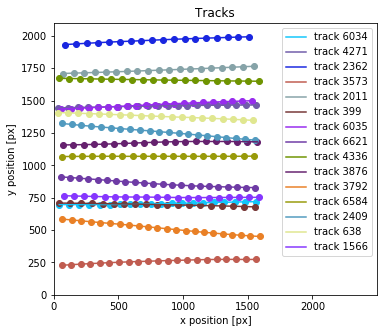

In [0]:
num_time_steps = 40
nan_value = 0
batch_size = 64

csv_data_set = data_manager.CsvDataSet('Pfeffer/trackSortResultPfeffer/*_trackHistory_NothingDeleted.csv',
                              timesteps=num_time_steps, nan_value=nan_value, batch_size=batch_size)

dataset_train, dataset_test = csv_data_set.get_tf_data_sets_seq2seq_data(normalized=True)

csv_data_set.plot_random_tracks(n=15)

In [0]:
!wget -N pollithy.com/rnn_model_fake_data.h5

--2020-01-09 18:56:30--  http://pollithy.com/rnn_model_fake_data.h5
Resolving pollithy.com (pollithy.com)... 87.118.94.85
Connecting to pollithy.com (pollithy.com)|87.118.94.85|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pollithy.com/rnn_model_fake_data.h5 [following]
--2020-01-09 18:56:30--  https://pollithy.com/rnn_model_fake_data.h5
Connecting to pollithy.com (pollithy.com)|87.118.94.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34203912 (33M)
Saving to: ‘rnn_model_fake_data.h5’

rnn_model_fake_data 100%[===================>]  32.62M  8.66MB/s    in 5.7s    

2020-01-09 18:56:37 (5.70 MB/s) - ‘rnn_model_fake_data.h5’ saved [34203912/34203912]



In [0]:
# load model
rnn_model = tf.keras.models.load_model('rnn_model_fake_data.h5')

# summarize model.
rnn_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_layer (Masking)      (64, 28, 2)               0         
_________________________________________________________________
rnn-0 (LSTM)                 (64, 28, 1024)            4206592   
_________________________________________________________________
rnn-1 (LSTM)                 (64, 28, 16)              66624     
_________________________________________________________________
dense_7 (Dense)              (64, 28, 2)               34        
Total params: 4,273,250
Trainable params: 4,273,250
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Masterarbeit Hornberger
# "Die auf den selbst gesammelten Daten trainierten Netze prädizieren von y ≈ 800 px nach y = 1550 px, also eine Distanz von ungefähr 750 px."
track_data, spatial_labels, temporal_labels = csv_data_set.get_separation_prediction_data(virtual_belt_edge_x_position=800, virtual_nozzle_array_x_position=1550)

# Normalize input
track_data /= csv_data_set.belt_width

track_data.shape, spatial_labels.shape, temporal_labels.shape

((6628, 40, 2), (6628, 2), (6628,))

In [0]:
def get_flat_state(rnn_model, lstm=True, batch_size=64, skip_layers=None):
    if skip_layers is None:
      skip_layers = []
    rnn_layer_states = None
    ith_stateful_layer = 0
    for i in range(1000):
        try:
            layer = rnn_model.get_layer(index=i)
        except:
            break

        if isinstance(layer, tf.keras.layers.RNN):
          ith_stateful_layer += 1
          if ith_stateful_layer in skip_layers:
            continue;

          for sub_state in layer.states:            
            # concat all states
            if rnn_layer_states is None:
              rnn_layer_states = sub_state.numpy()
            else:
              rnn_layer_states = np.concatenate((rnn_layer_states, sub_state.numpy()), axis=1)

    return rnn_layer_states

In [0]:
import logging
logging.getLogger('tensorflow').disabled = True

In [0]:
# create the hidden state for every track

last_states = []

for track_i in range(track_data.shape[0]):
  print(".", end="")
  rnn_model.reset_states()

  track = track_data[[track_i]]
  last_t = csv_data_set.get_last_timestep_of_track(track[0]) - 1

  for t in range(track.shape[1]):
    batch = np.repeat(track[:, [t], :], batch_size, axis=0)
    preds = rnn_model(batch)
    if t == last_t:
      last_states.append(get_flat_state(rnn_model, skip_layers=[])[0])
      break;
print("")

last_states = np.array(last_states)
print(last_states.shape)

num_tracks = last_states.shape[0]
track_data = track_data[:num_tracks]
spatial_labels = spatial_labels[:num_tracks]
temporal_labels = temporal_labels[:num_tracks]

last_states.shape, track_data.shape, spatial_labels.shape, temporal_labels.shape

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

((6628, 2080), (6628, 40, 2), (6628, 2), (6628,))

In [0]:
# create the hidden state for every track
last_states = None

for batch_i in range(track_data.shape[0] // batch_size):
  batch = track_data[batch_i*batch_size:(batch_i+1)*64]
  # assume track is shorter than 28 time steps -> this is true so far, but does not have to be in the future
  batch = batch[:, :28, :]

  rnn_model.reset_states()
  rnn_model(batch)

  state = get_flat_state(rnn_model, skip_layers=[])
  
  if last_states is None:
    last_states = state
  else:
    last_states = np.concatenate((last_states, state), axis=0)

num_tracks = last_states.shape[0]
track_data = track_data[:num_tracks]
spatial_labels = spatial_labels[:num_tracks]
temporal_labels = temporal_labels[:num_tracks]

last_states.shape, track_data.shape, spatial_labels.shape, temporal_labels.shape

((6592, 2080), (6592, 40, 2), (6592, 2), (6592,))

In [0]:
# Normalize y_preds
y_nozzle_preds = spatial_labels[:, [1]].copy()
y_norm_min = y_nozzle_preds.min()
print("min={}".format(y_norm_min))
y_nozzle_preds -= y_norm_min
y_norm_max = y_nozzle_preds.max()
print("max={}".format(y_norm_max))
y_nozzle_preds /= y_norm_max

min=110.40542347391816
max=2051.064261731135


In [0]:
y_nozzle_model = tf.keras.Sequential([
  tf.keras.layers.Dense(64, activation='relu', input_shape=[last_states.shape[1]]),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.Adam()

y_nozzle_model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])

y_nozzle_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                133184    
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 135,297
Trainable params: 135,297
Non-trainable params: 0
_________________________________________________________________


In [0]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, mode='min', patience=50, min_lr=0.0001, verbose=1)

history = y_nozzle_model.fit(
  last_states, y_nozzle_preds,
  epochs=200, validation_split = 0.1,
  callbacks=[reduce_lr])

Train on 5965 samples, validate on 663 samples
Epoch 1/200
5965/5965 [==============================] - 1s 208us/sample - loss: 0.0117 - mae: 0.0434 - mse: 0.0117 - val_loss: 2.8489e-04 - val_mae: 0.0134 - val_mse: 2.8489e-04
Epoch 2/200
5965/5965 [==============================] - 1s 143us/sample - loss: 2.9931e-04 - mae: 0.0132 - mse: 2.9931e-04 - val_loss: 2.7149e-04 - val_mae: 0.0128 - val_mse: 2.7149e-04
Epoch 3/200
5965/5965 [==============================] - 1s 140us/sample - loss: 2.8560e-04 - mae: 0.0130 - mse: 2.8560e-04 - val_loss: 2.5218e-04 - val_mae: 0.0123 - val_mse: 2.5218e-04
Epoch 4/200
5965/5965 [==============================] - 1s 140us/sample - loss: 2.9386e-04 - mae: 0.0133 - mse: 2.9386e-04 - val_loss: 2.8077e-04 - val_mae: 0.0136 - val_mse: 2.8077e-04
Epoch 5/200
5965/5965 [==============================] - 1s 140us/sample - loss: 2.5679e-04 - mae: 0.0124 - mse: 2.5679e-04 - val_loss: 2.2327e-04 - val_mae: 0.0117 - val_mse: 2.2327e-04
Epoch 6/200
5965/5965 [===

In [0]:
# Boxplot

# create the hidden state for every track
errors = np.array([])

for batch_i in range(last_states.shape[0] // batch_size):
  X = last_states[batch_i*batch_size:(batch_i+1)*batch_size]
  y = y_nozzle_preds[batch_i*batch_size:(batch_i+1)*batch_size]

  y_hat = y_nozzle_model(X)

  l1 = (y - y_hat).numpy()
  errors = np.concatenate((errors, l1.flatten()))
  
errors *= y_norm_max
np.median(errors)

-2.257421563740003

{'boxes': [<matplotlib.lines.Line2D at 0x7eff760eb208>],
 'caps': [<matplotlib.lines.Line2D at 0x7eff760ebcc0>,
 'fliers': [],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7eff76078390>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7eff760eb630>,
  <matplotlib.lines.Line2D at 0x7eff760eb978>]}

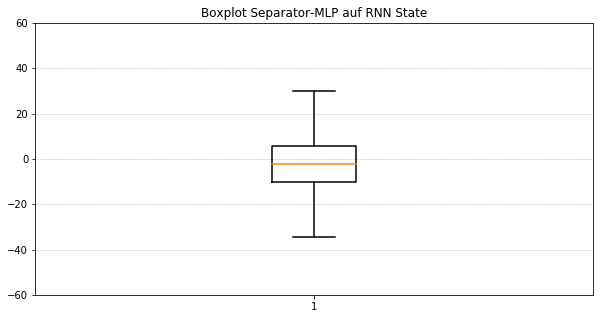

In [0]:
plt.rc('grid', linestyle=":")
fig1, ax1 = plt.subplots()
ax1.yaxis.grid(True)
ax1.set_ylim([-60, 60])
  
ax1.set_title('Boxplot Separator-MLP auf RNN State')
prop = dict(linewidth=1.5)
ax1.boxplot(errors, showfliers=False, boxprops=prop, whiskerprops=prop, medianprops=prop, capprops=prop)

In [0]:
temp_preds = temporal_labels[:, None].copy()
print("min={}".format(temp_preds.min()))
temp_preds -= temp_preds.min()
print("max={}".format(temp_preds.max()))
temp_preds /= temp_preds.max()

min=2.0565185152991416
max=19.706291772220204
